In [8]:
from google.colab import files
uploaded = files.upload()  # Upload Dataset2.zip here

# Unzip the dataset
import zipfile, os
zip_path = "Dataset2.zip"
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("/content/")
os.listdir("/content/Dataset2")

Saving Dataset2.zip to Dataset2 (1).zip


['.DS_Store', 'test', 'FNA']

In [9]:
!pip install tensorflow matplotlib pandas

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import pandas as pd
import random, shutil
from pathlib import Path

# Paths
DATASET = Path("/content/Dataset2")
FNA = DATASET / "FNA"
BENIGN = FNA / "benign"
MALIGNANT = FNA / "malignant"
TEST = DATASET / "test"
WORK = Path("/content/temp_split")

# Clean and prepare temp folders
if WORK.exists():
    shutil.rmtree(WORK)
(WORK / "train" / "benign").mkdir(parents=True, exist_ok=True)
(WORK / "train" / "malignant").mkdir(parents=True, exist_ok=True)
(WORK / "val" / "benign").mkdir(parents=True, exist_ok=True)
(WORK / "val" / "malignant").mkdir(parents=True, exist_ok=True)

# Split dataset (80/20)
def copy_split(src_dir, dst_train, dst_val, split=0.8, seed=123):
    files = list(src_dir.glob("*"))
    random.Random(seed).shuffle(files)
    ntrain = int(len(files) * split)
    for i, f in enumerate(files):
        shutil.copy(f, dst_train / f.name if i < ntrain else dst_val / f.name)

copy_split(BENIGN, WORK/"train"/"benign", WORK/"val"/"benign")
copy_split(MALIGNANT, WORK/"train"/"malignant", WORK/"val"/"malignant")

# Create datasets
IMG_SIZE = (128, 128)
BATCH = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    WORK/"train", labels='inferred', label_mode='binary',
    image_size=IMG_SIZE, batch_size=BATCH)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    WORK/"val", labels='inferred', label_mode='binary',
    image_size=IMG_SIZE, batch_size=BATCH)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data augmentation + normalization
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
])

# CNN model
inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train
cb = [callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
history = model.fit(train_ds, validation_data=val_ds, epochs=12, callbacks=cb)

Found 1379 files belonging to 2 classes.
Found 345 files belonging to 2 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,009 (6.48 MB)

 Trainable params: 1,699,009 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.6519 - loss: 0.6404 - val_accuracy: 0.8609 - val_loss: 0.3929
Epoch 2/12
44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8162 - loss: 0.4408 - val_accuracy: 0.8609 - val_loss: 0.3418
Epoch 3/12
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8717 - loss: 0.3255 - val_accuracy: 0.8986 - val_loss: 0.3122
Epoch 4/12
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8728 - loss: 0.3317 - val_accuracy: 0.8899 - val_loss: 0.2988
Epoch 5/12
44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8975 - loss: 0.2816 - val_accuracy: 0.8899 - val_loss: 0.3130
Epoch 6/12
44/44 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8938 - loss: 0.2898 - val_accuracy: 0.8986 - val_loss: 0.2817
Epoch 7/12
44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9001 - loss: 0.2780 - val_accuracy: 0.9101 - val_loss: 0.2820
Epoch 8/12
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8914 - loss: 0.2797 - val_accuracy: 0.8870 - val_loss:

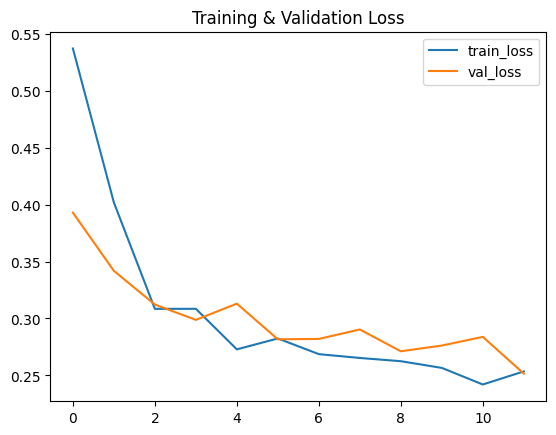

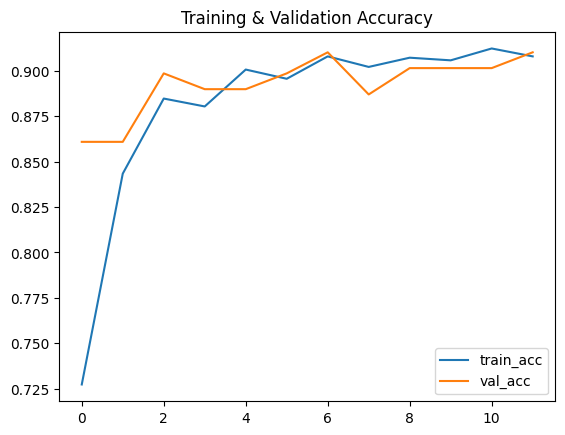

In [11]:
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Training & Validation Loss"); plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title("Training & Validation Accuracy"); plt.show()

In [12]:
import numpy as np, json

test_images = sorted(TEST.glob("*"))
preds = []
for p in test_images:
    img = tf.keras.preprocessing.image.load_img(p, target_size=IMG_SIZE)
    arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)
    prob = float(model.predict(arr)[0][0])
    label = "malignant" if prob >= 0.5 else "benign"
    preds.append({"filename": p.name, "prob_malignant": prob, "predicted": label})

df = pd.DataFrame(preds)
df.to_csv("/content/test_predictions.csv", index=False)
df.head(10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


,filename,prob_malignant,predicted
0,eight.png,0.000217,benign
1,eleven.png,0.000217,benign
2,five.png,0.000227,benign
3,four.png,0.000221,benign
4,fourteen.png,0.000217,benign
5,nine.png,0.000224,benign
6,one.png,0.000238,benign
7,seven.png,0.000228,benign
8,six.png,0.000236,benign
9,ten.png,0.000225,benign


✅ All results saved in /content/25MM60001_P5


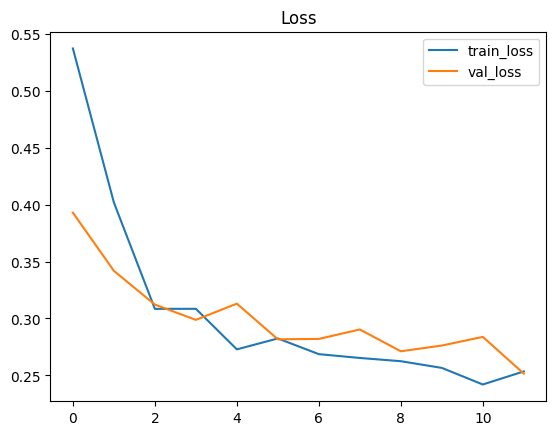

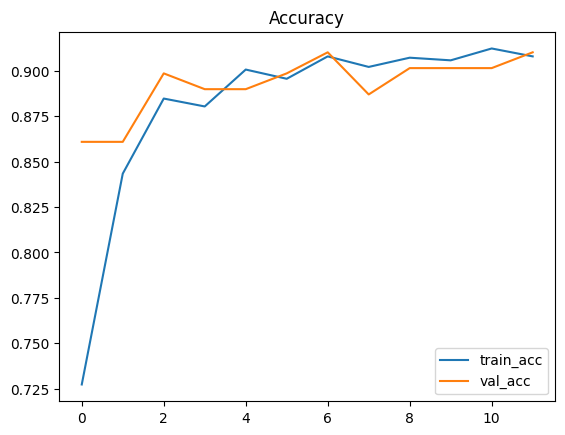

In [14]:
import os, shutil

OUTPUT = Path("/content/25MM60001_P5")
OUTPUT.mkdir(exist_ok=True)

model.save(OUTPUT / "model.h5")
df.to_csv(OUTPUT / "test_predictions.csv", index=False)

# Save training plots
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Loss")
plt.savefig(OUTPUT / "loss_plot.png")

plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title("Accuracy")
plt.savefig(OUTPUT / "acc_plot.png")

with open(OUTPUT / "README.txt", "w") as f:
    f.write(f"""Project: 25MM60001_P5
- model.h5 : trained Keras model
- test_predictions.csv : predicted labels for Dataset2/test
- loss_plot.png / acc_plot.png : training curves
""")

shutil.make_archive(str(OUTPUT), 'zip', str(OUTPUT))
print("✅ All results saved in", OUTPUT)